We, the ethereum smart contract project group from the [TIM](https://www.professors.wi.tum.de/tim/home/) Institute at the Technical University of Munich, show how to extract meaningful statistics of accounts of the Ethereum main network, from the data set hosted by Google BigQuery. This kernel is structured as follows.

Table of content:
1. Setting up Google Big Query and first queries
2. Identifying unique users
3. Creating a data set comprising all users' transactions
4. Identifying different types of users

*In progress:*
* *Creating a data set comprising different exogenous shocks (scams, regulations, forks, updates)*
* *Analyzing users reactions to exogenous shocks*
* *Contract to contract transactions (difficult to implement)*

# 1. Setting up Google Big Query (GBQ) and first queries
First, we have to import all necessary libraries and initialize a GBQ client and BigQueryHelper instance.

BigQueryHelper makes querying GBQ even easier on Kaggle. It has a function to automatically load queries into a pandas dataframe and provides an option to set a query limit. You can find it documentation [here](https://github.com/SohierDane/BigQuery_Helper).

As suggested [here](https://www.kaggle.com/mrisdal/visualizing-average-ether-costs-over-time?utm_medium=partner&utm_source=cloud&utm_campaign=big+data+blog+ethereum), we set a safety limit to control the quota of free queries provided by Kaggle. For this kernel, you will read a maximim of 120 GB from BigQuery. As the database size is constantly increasing, in the future you will incur in a error, if the amount of scanned data is greater than max_gb_scanned=40.

In [1]:
from google.cloud import bigquery
from bq_helper import BigQueryHelper
import pandas as pd

# This establishes an authenticated session and prepares a reference to the dataset that lives in BigQuery.
bq_assistant = BigQueryHelper("bigquery-public-data", "ethereum_blockchain")

# This initiates a google big query client without a reference to a specific dataset
client = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.
Using Kaggle's public dataset BigQuery integration.


bq_helper is planned to be deprecated. Please consider using from google.cloud import bigquery for reproducible kernels. See GBQ Documentation for details.

In [2]:
bq_assistant.list_tables()

['blocks',
 'contracts',
 'live_blocks',
 'live_contracts',
 'live_logs',
 'live_token_tokens',
 'live_token_traces',
 'live_token_transfers',
 'live_transactions',
 'logs',
 'token_transfers',
 'tokens',
 'traces',
 'transactions']

Here is an overview of different helpful functions comming along with the GBQ Helper.

In [3]:
# Quering GBQ with BigQueryHelper
    
    # BigQueryHelper Functions
# Queries dataset and returns a panda dataframe
##df = bq_assistant.query_to_pandas(query)

# Queries dataset and returns a panda dataframe + allows to set a max scan limit
##df = bq_assistant.query_to_pandas_safe(query, max_gb_scanned=40)

# Lists all tables in the dataset
##bq_assistant.list_tables()

# Shows the head of a specific table
##bq_assistant.head("table_name", num_rows=3)

# Shows details about colums 
##bq_assistant.table_schema("table_name")

# check estimated size of a query
##bq_assistant.estimate_query_size(query)

    # other usefull functions
# Print size of dataframe
##print('Size of dataframe: {} Bytes'.format(int(df.memory_usage(index=True, deep=True).sum())))


If GoogleBigQueryHelper for whatever reason does not work, you can also query the data set with the big query client. Below you find the respective code.

In [4]:
# Quering GBQ at Kaggle with GBQ client (without BigQueryHelper)
##query_job = client.query(query)

##iterator = query_job.result(timeout=30)
##rows = list(iterator)

# Transform the rows into a nice pandas dataframe
##df = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))

# Look at the first 10
##df.head(10)

Now, lets try different queries to get a first overview of the database We limit our query to blocks after the crypto bubble exploded.

In [5]:
# Query examples

min_block_number = 5100000
max_block_number = 5200000   #usually 6400000

# select distinct transaction senders within a given range of blocks 
query_1 = """
SELECT DISTINCT
    from_address AS sender, block_number AS block_number
FROM
    `bigquery-public-data.ethereum_blockchain.transactions`
WHERE
    block_number > %d
    AND
    block_number < %d
"""

# select distinct transaction senders within a given range of blocks
query_2 = """
SELECT DISTINCT
    to_address AS receipient, block_number AS block_number
FROM
    `bigquery-public-data.ethereum_blockchain.transactions`
WHERE
    block_number > %d
    AND
    block_number < %d
"""

# select transaction senders that are contracts 
query_3 = """
SELECT
    DISTINCT address AS sc_address, is_erc20, is_erc721, block_number AS block_number
FROM
    `bigquery-public-data.ethereum_blockchain.contracts`
WHERE
    block_number > %d
    AND
    block_number < %d
"""

In [6]:
# query_1: unique senders
unique_senders = bq_assistant.query_to_pandas_safe(query_1 % (min_block_number, max_block_number), max_gb_scanned=52)
print("Retrieved " + str(len(unique_senders)) + " unique_senders.")
print(unique_senders.head(10))

Retrieved 8699089 unique_senders.
                                       sender  block_number
0  0xceceaa8edc0830c7cec497e33bb3a3c28dd55a32       5199733
1  0x3b82e4bf46dbd381695b3601c522f90cf3e51e43       5199102
2  0x094210ea846116dde8230cd9f1b98db99d6e7b76       5199695
3  0x05be6e1f661dacd4630e1ebe2ffce5bfb962076f       5198843
4  0x367328fd0b0eca0afa9f8c63fd732d2a2ccc7557       5199477
5  0x00bdb5699745f5b860228c8f939abf1b9ae374ed       5199467
6  0x3a32205e092f89314e71e57916c979e58f33ff53       5199282
7  0xfe4d1b77fd3a0a1ea4a28b163bc5fbd0c57a0b46       5198566
8  0xabd5b9c2fc1a84785efe8d8b6a2c1e7898d24277       5198906
9  0x057acf91a311c348991c125e153d85920c20d446       5198726


In [7]:
# query_2: unique recipients
unique_receipients = bq_assistant.query_to_pandas_safe(query_2 % (min_block_number, max_block_number), max_gb_scanned=52)
print("Retrieved " + str(len(unique_receipients)) + " unique_receipients.")
print(unique_receipients.head(10))

Retrieved 8696348 unique_receipients.
                                   receipient  block_number
0  0x6748746ebd1e29c14e16ff1fa607578e26e3b914       5198350
1  0x6cabf1b590ee8daa30a1c76ff5dd21284d8681d8       5199122
2  0x6cabf1b590ee8daa30a1c76ff5dd21284d8681d8       5199459
3  0x9600fbd9dd97407c5230a6fb4ce1a1bce388e894       5198559
4  0x9a2d163ab40f88c625fd475e807bbc3556566f80       5198722
5  0xaf0e27602eaa73fdf4849806d75bdfc77fb95217       5199770
6  0xccc1d3102703418cfda055ce688867268563b3e6       5198485
7  0xccc1d3102703418cfda055ce688867268563b3e6       5197763
8  0xccc1d3102703418cfda055ce688867268563b3e6       5199091
9  0x618e75ac90b12c6049ba3b27f5d5f8651b0037f6       5199173


In [8]:
# query_3: unique contracts
unique_contracts = bq_assistant.query_to_pandas_safe(query_3 % (min_block_number, max_block_number), max_gb_scanned=52)
print("Retrieved " + str(len(unique_contracts)) + " unique_contracts.")
print(unique_contracts.head(10))

Retrieved 272887 unique_contracts.
                                   sc_address  is_erc20  is_erc721  \
0  0xee614765ccc9c4e077d6bc78620c535437866bd1     False      False   
1  0x9a33f1b50b96e7a1f7d541db52b701ba02a17768     False      False   
2  0xef96fa7b9a1656938603537736817cc0b4d8a0ce     False      False   
3  0xe12353413b3d0a729e8e37c49c425d1b6c46c233     False      False   
4  0x29cd2f7332aa41289ac6c438ee2e3fe0b134f1b5      True      False   
5  0x57bb029e80cf3f208b3f1138081ec324e9fbf713      True      False   
6  0x72e819d3ac4d7fe45bc9bb1a4f35158c377c985d      True      False   
7  0xfb5c1935f419227a283b9f9f551530fd8053126a      True      False   
8  0x01293cd77f68341635814c35299ed30ae212789e     False      False   
9  0xbe6f948d1e1a51bd5ede074ab0394e2ae89701df     False      False   

   block_number  
0       5113930  
1       5109652  
2       5110271  
3       5111543  
4       5112339  
5       5110313  
6       5112134  
7       5112799  
8       5114623  
9       511365

# 2. Identifying unique users

Ok, we obtained the list of most popular addresses and printed the top ten. A quick check of the addresses on a blockchain explorer (https://etherscan.io/) tells us that they are all associated with currency exchanges or popular decentralized applications (dApps). We might expect that the accounts follow a power-law, where the most "active" accounts are owned by centralized exchanges. Is it true?

In [9]:
from google.cloud import bigquery
from bq_helper import BigQueryHelper
import pandas as pd

bq_assistant = BigQueryHelper("bigquery-public-data", "ethereum_blockchain")
client = bigquery.Client()

min_block_number = 5100000
max_block_number = 6400000

# find average values and sort
query = """
SELECT
  address, SUM(n_updates) AS updates
FROM
(
  SELECT
      address, COUNT(*) AS n_updates
  FROM
  (
  SELECT DISTINCT
    from_address AS address, block_number AS block_number
  FROM
    `bigquery-public-data.ethereum_blockchain.transactions`
  WHERE
    block_number > %d
    AND
    block_number < %d
  )
  GROUP BY 
    address

  UNION ALL

  SELECT 
      address AS address, COUNT(*) AS n_updates
  FROM
  (
  SELECT DISTINCT
    to_address AS address, block_number AS block_number
  FROM
    `bigquery-public-data.ethereum_blockchain.transactions`
  WHERE
    block_number > %d
    AND
    block_number < %d
  )
  GROUP BY 
    address
)
WHERE
  n_updates >= 5
  AND
  address IS NOT NULL
GROUP BY 
  address
ORDER BY 
  updates DESC
"""

most_populars = bq_assistant.query_to_pandas_safe(query % (min_block_number, max_block_number, min_block_number, max_block_number), max_gb_scanned=100)
print("Retrieved " + str(len(most_populars)) + " accounts.")
blocks_int = max_block_number - min_block_number
most_populars = most_populars.sort_values(by='updates', ascending=False)
most_populars["probability"] = most_populars["updates"] / (blocks_int*1.0)
print(most_populars.head(10))

Using Kaggle's public dataset BigQuery integration.
Using Kaggle's public dataset BigQuery integration.
Retrieved 3200906 accounts.
                                      address  updates  probability
0  0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208   826322     0.635632
1  0x8d12a197cb00d4747a1fe03395095ce2a5cc6819   678992     0.522302
2  0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be   516487     0.397298
3  0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98   443274     0.340980
4  0x06012c8cf97bead5deae237070f9587f8e7a266d   441706     0.339774
5  0xf5bec430576ff1b82e44ddb5a1c93f6f9d0884f3   426358     0.327968
6  0x86fa049857e0209aa7d9e616f7eb3b3b78ecfdb0   391816     0.301397
7  0x70faa28a6b8d6829a4b1e649d26ec9a2a39ba413   370923     0.285325
8  0x2b5634c42055806a59e9107ed44d43c426e58258   368198     0.283229
9  0xc179fbddc946694d11185d4e15dbba5fd0adac0a   350727     0.269790


Fit with values -0.631111395667246 0.8886528163778137 -0.0001485213358004082


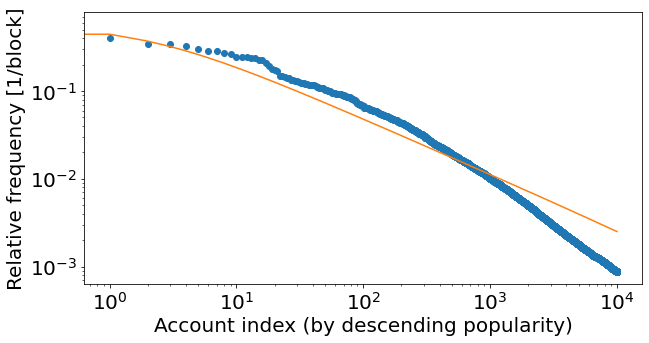

In [10]:
from scipy.optimize import curve_fit
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import numpy as np

def func_powerlaw(x, m, c, c0):
    return c0 + x**m * c

blocks_int = max_block_number - min_block_number

# Compute probabilities
most_populars["probability"] = most_populars["updates"] / (blocks_int*1.0)
most_populars["idxs"] = range(1, len(most_populars) + 1)

# Fit curve
sol = curve_fit(func_powerlaw, most_populars["idxs"], most_populars["probability"], p0 = np.asarray([float(-1),float(10**5),0]))
fitted_func = func_powerlaw(most_populars["idxs"], sol[0][0], sol[0][1], sol[0][2])
print("Fit with values {} {} {}".format(sol[0][0], sol[0][1], sol[0][2]))

# Plot fit vs samples (only for the first 2000)
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(10,5))
plt.loglog(most_populars["probability"].tolist()[1:10000],'o')
plt.loglog(fitted_func.tolist()[1:10000])
plt.xlabel("Account index (by descending popularity)")
plt.ylabel("Relative frequency [1/block]")
plt.show()

We plot the relative frequency of accounts that are modified at least once per hour (there are approximately 10k of them in the main network). Their relative frequency doesn't follow a "simple" power-law, because the 20 most popular accounts have "equal power", i.e. they show similar activity. A broken power-law would be more appropriate, as we have observed in a recent paper. In that document, you can find more insights about how to use the statistics of accounts to design better protocols.

# 3. Statistics of specific accounts

We can also observe the activity of specific accounts. For example, the following query returns the block numbers (and their timestamp) at which an account has been modified. We apply it to two addresses: one associated with CryptoKitties dApp, and one with Bittrex exchange, that are characterized by similar relative frequency of updates.

In [11]:
import matplotlib.pyplot as plt
import numpy as np

query = """
SELECT 
      timestamp, number
    FROM
      `bigquery-public-data.ethereum_blockchain.blocks`
INNER JOIN 
(
    SELECT DISTINCT
              from_address AS address, block_number AS block_number
            FROM
              `bigquery-public-data.ethereum_blockchain.transactions`
            WHERE
              from_address = '%s'
              AND
              block_number > %d
              AND
              block_number < %d

    UNION DISTINCT

    SELECT DISTINCT
              to_address AS address, block_number AS block_number
            FROM
              `bigquery-public-data.ethereum_blockchain.transactions`
            WHERE
              to_address = '%s'
              AND
              block_number > %d
              AND
              block_number < %d
) as InnerTable
ON 
    `bigquery-public-data.ethereum_blockchain.blocks`.number = InnerTable.block_number;
"""

# CryptoKitties address
adx_1 = most_populars.iloc[4].address 
transax_1 = bq_assistant.query_to_pandas_safe(query % (adx_1, min_block_number, max_block_number, adx_1, min_block_number, max_block_number), max_gb_scanned=60)
print("Retrieved " + str(len(transax_1)) + " blocks for account %s." % (adx_1) )
transax_1.sort_values(by="number", ascending=True, inplace=True)
    
# Bittrex address    
adx_2 = most_populars.iloc[3].address 
transax_2 = bq_assistant.query_to_pandas_safe(query % (adx_2, min_block_number, max_block_number, adx_2, min_block_number, max_block_number), max_gb_scanned=60)
print("Retrieved " + str(len(transax_2)) + " blocks for account %s." % (adx_2) )
transax_2.sort_values(by="number", ascending=True, inplace=True)
    
transax = list()
transax.append(transax_1)
transax.append(transax_2)

Retrieved 441706 blocks for account 0x06012c8cf97bead5deae237070f9587f8e7a266d.
Retrieved 443230 blocks for account 0xfbb1b73c4f0bda4f67dca266ce6ef42f520fbb98.


From the results, it is possible to extract several interesting statistics. For example, the cumulative density function (CDF) of number of blocks between two consecutive updates to the account. The knowledge of the CDF is important to design and evaluate the performances of blockchain lightweight protocols. For example, we can decide to sync our blockchain client periodically, and tune the period based on the statistics of the account that we are interested in.

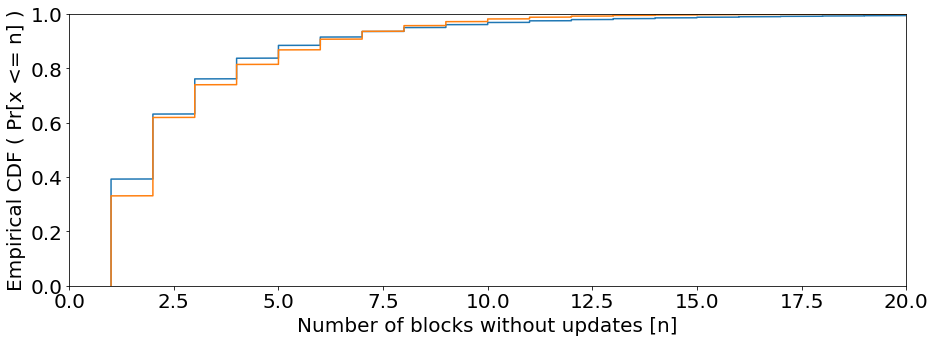

In [12]:
# plot the Empirical CDF

plt.figure(figsize=(15,5))
for t in transax:
    t.sort_values(by="number", inplace=True)
    tx_d = t.diff()
    tx_d = tx_d.iloc[1:]
    count = np.sort(tx_d["number"].values)
    cdf = np.arange(len(count)+1)/float(len(count))
    plt.plot(count, cdf[:-1])

plt.axis([0, 20, 0, 1])
plt.xlabel("Number of blocks without updates [n]")
plt.ylabel("Empirical CDF ( Pr[x <= n] )")
plt.show()

We can also look for specific activity patterns. For example, in the figure below we show that, even if the two accounts show the same relative frequency on average, their activity is not stationary.

Other question: on which day of the week are the two accounts more active? The bar figures show that CryptoKitties, that is a game, is particularly used during the weekends. On the other hand, Bittrex is active on Mondays and Tuesdays and on Friday, that is quite expected for a trading platform.

/opt/conda/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/opt/conda/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will alwa

Text(0.5, 1.0, 'Bittrex')

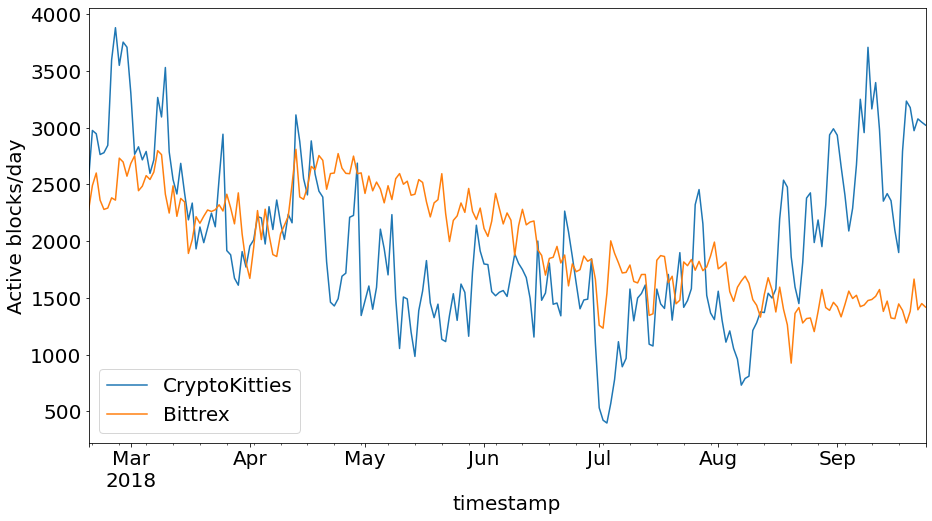

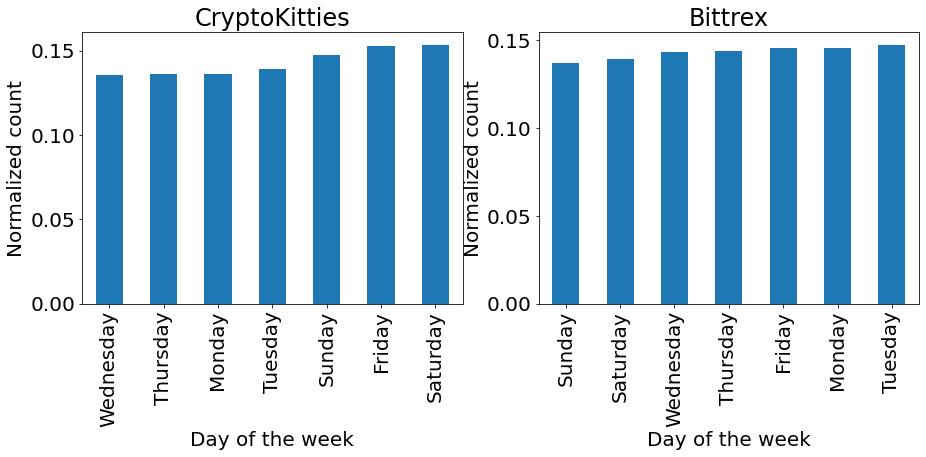

In [13]:
# activity during time
txp_1 = transax_1["timestamp"].groupby(transax_1["timestamp"].dt.floor('d')).size().reset_index(name='CryptoKitties')
txp_2 = transax_2["timestamp"].groupby(transax_2["timestamp"].dt.floor('d')).size().reset_index(name='Bittrex')
txp_1 = txp_1[2:-2]
txp_2 = txp_2[2:-2]

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
ax = txp_1.plot(x="timestamp", y="CryptoKitties", ax=ax)
ax = txp_2.plot(x="timestamp", y="Bittrex", ax=ax)
plt.ylabel("Active blocks/day")

# patterns
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

plt.subplot(1, 2, 1)
txp_1 = transax_1["timestamp"].groupby(transax_1["timestamp"].dt.day_name()).count().sort_values()
txp_1 /= sum(txp_1)
txp_1.plot(kind="bar", ax=ax)
plt.xlabel("Day of the week")
plt.ylabel("Normalized count")
plt.title("CryptoKitties")

plt.subplot(1, 2, 2)
txp_2 = transax_2["timestamp"].groupby(transax_2["timestamp"].dt.day_name()).count().sort_values()
txp_2 /= sum(txp_2)
txp_2.plot(kind="bar", ax=ax2)
plt.xlabel("Day of the week")
plt.ylabel("Normalized count")
plt.title("Bittrex")

# 4. Identifying different types of users

To gain a more thorough understanding of the composition of the ethereum community, we divide unique users into the following groups:

1. **Deployers**: addresses that have created contracts (includes both users and contracts)
2. **Heavy users**: categorising unique users by updates (= mention in txn as from_address or to_address)
3. **Investors**: accounts that participated in several ICOs

Subsequently, we use these groups to analyse the behaviour, interrelation and development of the community.

The timeframe we observe is between block 5,100,000 (February 16th, 2018) and block 6,400,000 (September 26th, 2018) which limits the study to a range of blocks after the "explosion" of the crypto bubble.

Several queries, especially of the contract deployers were taken in part from the publicly available master's thesis:

> A. Voulgari, 2019, "Ethereum Analytics", ETH Zürich

In [14]:
# 0 Getting started
from google.cloud import bigquery
from bq_helper import BigQueryHelper
import pandas as pd

bq_assistant = BigQueryHelper("bigquery-public-data", "ethereum_blockchain")

Using Kaggle's public dataset BigQuery integration.


In [15]:
# 1.1 Query for unique deployers ordered by contract count including first and last creation timestamps
query_deployers = """
SELECT
    DISTINCT from_address AS unique_deployer,
    COUNT(1) AS contracts_deployed,
    MIN(block_timestamp) AS first_event,
    MAX(block_timestamp) AS last_event,
    DATE_DIFF(DATE(MAX(block_timestamp)),DATE(MIN(block_timestamp)),day) AS days_active
FROM   `bigquery-public-data.ethereum_blockchain.transactions`
        WHERE
        
        block_number < 6400000 
        AND
        block_number > 5100000 
        AND
        to_address IS null
        AND
        receipt_status = 1
    GROUP BY
        from_address
    HAVING
        COUNT(1) > 4
    ORDER BY
        contracts_deployed DESC
"""

deployers = bq_assistant.query_to_pandas_safe(query_deployers, max_gb_scanned=100)
deployers.describe()

,contracts_deployed,days_active
count,6297.000000,6297.000000
mean,88.637129,40.804510
std,1928.297980,52.518537
min,5.000000,0.000000
25%,6.000000,1.000000
50%,8.000000,15.000000
75%,13.000000,66.000000
max,95333.000000,222.000000


The above table summarises the data of contract deployers by number of contracts deployed. The large discrepancy in contracts deployed and the relatively small timeframes give rise to question the uniqueness of these contracts.
As a result, we first analyse this data in a graph and afterwards find out the uniqueness of the contract bytecode.

In [16]:
# 1.1 continued: Summary of unique deployers ordered by number of deployed contracts (limited to 95th percentile)
deployers2 = deployers[deployers.contracts_deployed < deployers.contracts_deployed.quantile(.95)]
deployers2.describe()

,contracts_deployed,days_active
count,5982.000000,5982.000000
mean,10.524574,38.207121
std,7.520133,49.758108
min,5.000000,0.000000
25%,6.000000,1.000000
50%,8.000000,14.000000
75%,12.000000,61.750000
max,47.000000,215.000000


Looking at numbers of contracts_deployed below the 95th percentile to roughly removes the largest outliers.

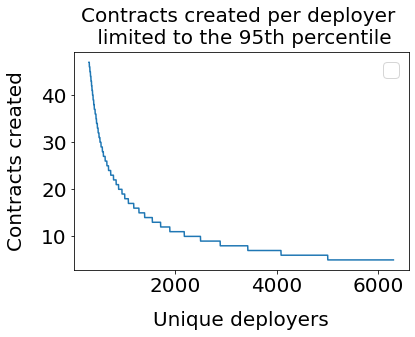

In [17]:
# 1.1 continued: Graph for unique deployers ordered by number of deployed contracts (limited to 95th percentile)
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
plt.plot(deployers2.contracts_deployed)
plt.title("Contracts created per deployer \n limited to the 95th percentile", y=1.01, fontsize=20)
plt.ylabel("Contracts created", labelpad=15)
plt.xlabel("Unique deployers", labelpad=15)
plt.legend()


In the next step, we look at unique and duplicate bytecodes created by contract deployers.

In [18]:
# 1.2 Querying unique vs duplicate bytecodes in contract creation
query_dupl_bytecode = """
SELECT DISTINCT creator, COUNT(occurrence) as duplicates_creator, SUM(occurrence) AS duplicates, SUM(uniques) AS uniques
FROM (
  SELECT
    DISTINCT(output) AS bytecode,
    from_address,
    CASE
      WHEN trace_address IS NOT NULL THEN 'contract'
    ELSE
    'user'
  END
    AS creator,
    CASE
      WHEN COUNT(*) > 1 THEN COUNT(*)
  END
    AS occurrence,
    CASE
      WHEN COUNT(*) = 1 THEN 1
  END
    AS uniques
  FROM
    `bigquery-public-data.crypto_ethereum.traces`
  WHERE
    trace_type = 'create'
    AND status = 1
    AND block_number > 5400000
    AND block_number < 6100000
  GROUP BY
    from_address,
    bytecode,
    creator)
    GROUP BY creator
"""

dupl_bytecode = bq_assistant.query_to_pandas_safe(query_dupl_bytecode, max_gb_scanned=500)
print(dupl_bytecode)

    creator  duplicates_creator  duplicates  uniques
0      user                7938      273365    42119
1  contract                2620      764634     9363


This query was executed via the 'traces' dataset which contains both user-created contracts and contract-created contracts. When the trace_address is null the creator is a user, because the trace was executed directly, not through another trace.

We only considered bytecodes as duplicates when they exactly match each other without accounting for ones that are very similar. Even so, the result shows that only 2620 contracts were responsible for the creation of 764,634 contracts.

To get a better grasp of the contract deployers, we next have a look at contract creation by non-contracts only over time.

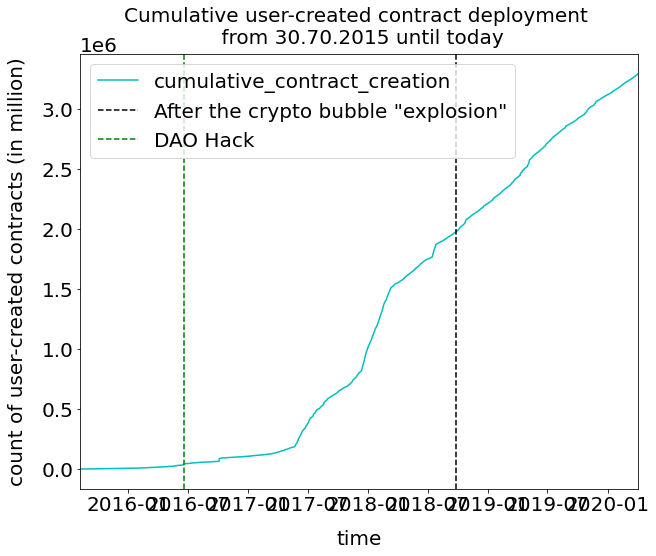

In [19]:
# 1.3 Querying user-created contract deployments over time
import matplotlib.pyplot as plt

query_contract_growth = """
WITH
  a AS (
  SELECT
    DATE(block_timestamp) AS date,
    COUNT(*) AS contracts_creation
  FROM
    `bigquery-public-data.crypto_ethereum.traces` AS traces
  WHERE
    trace_type = 'create'
    AND trace_address IS NULL
  GROUP BY
    date),
  b AS (
  SELECT
    date,
    SUM(contracts_creation) OVER (ORDER BY date) AS ccc,
    LEAD(date, 1) OVER (ORDER BY date) AS next_date
  FROM
    a
  ORDER BY
    date),
  calendar AS (
  SELECT
    date
  FROM
    UNNEST(GENERATE_DATE_ARRAY('2015-07-30', CURRENT_DATE())) AS date),
  c AS (
  SELECT
    calendar.date,
    ccc
  FROM
    b
  JOIN
    calendar
  ON
    b.date <= calendar.date
    AND calendar.date < b.next_date
  ORDER BY
    calendar.date)
SELECT
  DATE,
  ccc AS cumulative_contract_creation
FROM
  c
ORDER BY
  date desc
"""

contract_growth = bq_assistant.query_to_pandas_safe(query_contract_growth, max_gb_scanned=500)

contract_growth.plot(x='DATE', y='cumulative_contract_creation', kind='line', 
        figsize=(10, 8), legend=False, style='c-')
plt.title("Cumulative user-created contract deployment \n from 30.70.2015 until today", y=1.01, fontsize=20)
plt.axvline(pd.Timestamp('2018-09-27'),color='black',linestyle='--', label='After the crypto bubble "explosion"')
plt.axvline(pd.Timestamp('2016-06-18'),color='green',linestyle='--', label='DAO Hack')
plt.ylabel("count of user-created contracts (in million)", labelpad=15)
plt.xlabel("time", labelpad=15)
plt.legend()

This plot illustrates the development trajectory of user-created contracts between July 30th 2015 and today. The red line signifies June 18th, 2016, the date of the DAO Hack. The black line represents September 27th, 2018, the approximate date at which the crypto bubble exploded.

In [20]:
# 2.1 Query for heavy users (preliminary analysis of users with 200 to 2000 updates)
min1 = 200
max1 = 2000
min2 = 100
max2 = 1000
min3 = 400
max3 = 4000
min4 = 50
max4 = 4000
query_accounts_updates = """
SELECT 
    address, 
    SUM(n_updates) AS updates,
    first_txn,
    last_txn,
    DATE_DIFF(DATE(last_txn),DATE(first_txn),day) AS days_active,
    (CASE WHEN address IN (SELECT DISTINCT address FROM `bigquery-public-data.crypto_ethereum.contracts`) THEN TRUE
    ELSE FALSE END) AS IsContract
FROM 
(
    SELECT 
        address, 
        count(*) AS n_updates, 
        MIN(block_timestamp) AS first_txn,
        MAX(block_timestamp) AS last_txn
        FROM
        (
            SELECT 
                DISTINCT from_address AS address, 
                block_number AS block_number, 
                block_timestamp AS block_timestamp
                FROM 
                    `bigquery-public-data.ethereum_blockchain.transactions`
                    WHERE 
                    block_number < 6400000 
                    AND 
                    block_number > 5100000
        )
    GROUP BY address
    UNION ALL
    SELECT 
        address AS address, 
        count(*) AS n_updates,
        MIN(block_timestamp) AS first_txn,
        MAX(block_timestamp) AS last_txn
        FROM 
        (
            SELECT 
                DISTINCT to_address AS address, 
                block_number AS block_number, 
                block_timestamp AS block_timestamp
                FROM 
                    `bigquery-public-data.ethereum_blockchain.transactions`
                    WHERE 
                    block_number < 6400000 
                    AND 
                    block_number > 5100000
        )
        GROUP BY address
)
WHERE n_updates >= %s 
AND
n_updates <= %s
AND
address IS NOT NULL
GROUP BY 
    address,
    first_txn,
    last_txn,
    IsContract
ORDER BY 
    updates DESC
"""

accounts_updates1 = bq_assistant.query_to_pandas_safe(query_accounts_updates % (min1, max1), max_gb_scanned=65)
heavy_users1 = accounts_updates1.loc[accounts_updates1['IsContract'] == False]
heavy_users1.describe()

,updates,days_active
count,45869.000000,45869.000000
mean,450.759336,148.629532
std,346.604326,73.611392
min,200.000000,0.000000
25%,229.000000,88.000000
50%,305.000000,176.000000
75%,512.000000,217.000000
max,2000.000000,222.000000


In the previous query, we used a range of 200 to 2000 updates because preliminary analyses revealed that the spread of users per update_count above and below that range distorts the data and produces a large amount of outliers.

To illustrate this spread, the following query shows the ranges from:
* 200 to 2000 updates
* 100 to 1000 updates
* 400 to 4000 updates
* 50 to 4000 updates

To create the different subsets, we created variables at the start of the previous query which are now inserted into the query using the query_to_pandas_safe function.

In [21]:
# 2.1 continued: Histrogram to show the distribution of heavy users by updates (200 to 2000 updates)
import matplotlib.pyplot as plt

accounts_updates2 = bq_assistant.query_to_pandas_safe(query_accounts_updates % (min2, max2), max_gb_scanned=65)
heavy_users2 = accounts_updates2.loc[accounts_updates2['IsContract'] == False]
accounts_updates3 = bq_assistant.query_to_pandas_safe(query_accounts_updates % (min3, max3), max_gb_scanned=65)
heavy_users3 = accounts_updates3.loc[accounts_updates3['IsContract'] == False]
accounts_updates4 = bq_assistant.query_to_pandas_safe(query_accounts_updates % (min4, max4), max_gb_scanned=65)
heavy_users4 = accounts_updates4.loc[accounts_updates4['IsContract'] == False]

plt.gcf().set_size_inches(10.5, 10.5)

#subplot with 200 to 2000 updates
plt.subplot(221)
plt.plot(heavy_users1.updates)
plt.title('200 to 2000 updates')

#subplot with 100 to 1000 updates
plt.subplot(222)
plt.plot(heavy_users2.updates)
plt.title('100 to 1000 updates')

#subplot with 400 to 4000 updates
plt.subplot(223)
plt.plot(heavy_users3.updates)
plt.title('400 to 4000 updates')

#subplot with 50 to 4000 updates
plt.subplot(224)
plt.plot(heavy_users4.updates)
plt.title('50 to 4000 updates')

plt.show()

We continue with the range of 200 to 2000 updates.
To be able to put into relation the distribution of user updates with contract updates, we compare users and contracts in a stacked barplot.

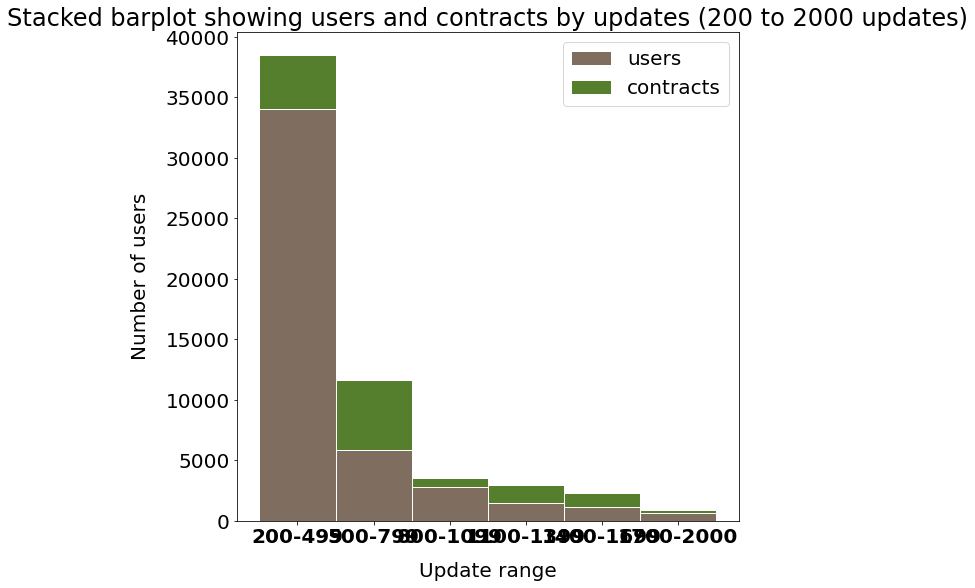

In [22]:
# 2.2: Bargraph of users vs contracts by udpates (200 to 2000 updates)
import matplotlib.pyplot as plt
import numpy as np

plt.gcf().set_size_inches(9,9)

#bar position
r = [0,1,2,3,4,5]

#bar labels
labels = ['200-499','500-799','800-1099','1100-1399','1400-1699','1700-2000']

#split data by IsContract
users = accounts_updates1.loc[accounts_updates1['IsContract'] == False]
contracts = accounts_updates1.loc[accounts_updates1['IsContract'] == True]

#group splitted data by update counts
users_by = users.groupby('updates').size().reset_index(name='counts')
contracts_by = contracts.groupby('updates').size().reset_index(name='counts')

#split data into selected columns
users_bars = [users_by.loc[users_by['updates']< 500]['counts'].sum(),users_by.loc[(users_by['updates']>= 500) & (users_by['updates'] < 800)]['counts'].sum(),users_by.loc[(users_by['updates']>= 800) & (users_by['updates'] < 1100)]['counts'].sum(),users_by.loc[(users_by['updates']>= 1100) & (users_by['updates'] < 1400)]['counts'].sum(),users_by.loc[(users_by['updates']>= 1400) & (users_by['updates'] < 1700)]['counts'].sum(), users_by.loc[users_by['updates'] >= 1700]['counts'].sum()]
contracts_bars = [contracts_by.loc[contracts_by['updates']< 500]['counts'].sum(),users_by.loc[(users_by['updates']>= 500) & (users_by['updates'] < 800)]['counts'].sum(),contracts_by.loc[(contracts_by['updates']>= 800) & (contracts_by['updates'] < 1100)]['counts'].sum(),users_by.loc[(users_by['updates']>= 1100) & (users_by['updates'] < 1400)]['counts'].sum(),users_by.loc[(users_by['updates']>= 1400) & (users_by['updates'] < 1700)]['counts'].sum(), contracts_by.loc[contracts_by['updates'] >= 1700]['counts'].sum()]

#plot stacked bargraph
plt.bar(r, users_bars, color='#7f6d5f', edgecolor='white', width=1, label = 'users')
plt.bar(r, contracts_bars, bottom=users_bars, color='#557f2d', edgecolor='white', width=1,label = 'contracts')
plt.xticks(r, labels, fontweight='bold')
plt.title('Stacked barplot showing users and contracts by updates (200 to 2000 updates)')
plt.ylabel("Number of users", labelpad=15)
plt.xlabel("Update range", labelpad=15)
plt.legend()
plt.show()

To arrive at the stacked barplot, we first split the existing data by 'IsContract' into users and contracts. Subsequently, we grouped the data by 'updates' and then split this data again by bin-sizes. For each bin-size, we computed the total count of users / contracts within that range and then stacked the bars on top of each other.

We now continue by examining the next user group: the token investors.

In [23]:
# 3.1 All Investors ordered by tokens (extensive query explanation below)

query_token_investors = """
WITH
  #date of first transfer per token (used in every transfer query to select transfers within x days from first transfer --> ICO date)
  first_trf AS(
  SELECT
    DISTINCT tr.token_address AS token,
    MIN(tr.block_timestamp) AS time
  FROM
    `bigquery-public-data.ethereum_blockchain.token_transfers` AS tr
  WHERE
    tr.block_number BETWEEN 510000
    AND 6400000
  GROUP BY
    tr.token_address)
  ,
    #issuer per token (issuer: most occuring from_address per token within 15 days of first token transfer)
  issuer AS (
    #select from_address with highest occurrence (occurrence = max_count) per token --> issuer
  SELECT
    DISTINCT tt.token_address AS token1,
    tt.from_address AS issuer1,
    COUNT(tt.from_address) AS c1
  FROM
    `bigquery-public-data.ethereum_blockchain.token_transfers` AS tt
  INNER JOIN (
      #select max_count per token
    SELECT
      token_address,
      MAX(c) AS maxCount
    FROM (
        #count occurrence of from_addresses (potential issuer) per token
      SELECT
        token_address,
        from_address,
        COUNT(from_address) AS c
      FROM
        `bigquery-public-data.ethereum_blockchain.token_transfers`
      JOIN
        first_trf
      ON
        token_address = first_trf.token
      WHERE
        CAST(block_timestamp AS date) <= DATE_ADD(CAST(first_trf.time AS date),INTERVAL 15 DAY)
        AND block_number BETWEEN 5100000
        AND 6400000
      GROUP BY
        token_address,
        from_address)AS tt1
    GROUP BY
      token_address) AS groupedtt
  ON
    tt.token_address = groupedtt.token_address
  JOIN
    first_trf
  ON
    tt.token_address = first_trf.token
  WHERE
    CAST(tt.block_timestamp AS date) <= DATE_ADD(CAST(first_trf.time AS date),INTERVAL 15 DAY)
    AND tt.block_number BETWEEN 5100000
    AND 6400000
  GROUP BY
    tt.token_address,
    tt.from_address,
    groupedtt.maxCount
  HAVING
    groupedtt.maxCount = c1
    AND c1 > 1)
  #select all investors who have once sent a transaction to that contract (cross-check)
SELECT
  investor,
  token_contract,
  token_issuer,
  first_transfer
FROM (
    #select all investors (investors =^ to_addresses that received a token transfer from the respective issuer)
  SELECT
    DISTINCT t.to_address AS investor,
    symbol,
    issuer.token1 AS token_contract,
    issuer.issuer1 AS token_issuer,
    first_trf.time AS first_transfer
  FROM
    `bigquery-public-data.ethereum_blockchain.token_transfers` AS t
  JOIN
    issuer
  ON
    issuer.issuer1 = t.from_address
    AND issuer.token1 = t.token_address
  JOIN
    `bigquery-public-data.ethereum_blockchain.tokens`
  ON
    address = t.token_address
  JOIN
    first_trf
  ON
    first_trf.token = issuer.token1
  WHERE
    CAST(t.block_timestamp AS date) <= DATE_ADD(CAST(first_trf.time AS date),INTERVAL 15 DAY)
    AND t.block_number BETWEEN 5100000
    AND 6400000
  GROUP BY
    investor,
    token_issuer,
    token1,
    symbol,
    first_trf.time)
  #crosscheck that investor has once made txn to token_contract
INNER JOIN
  `bigquery-public-data.ethereum_blockchain.transactions`
ON
  investor = from_address
WHERE
  to_address = token_contract
GROUP BY
  token_contract,
  investor,
  token_issuer,
  first_transfer
ORDER BY
  token_contract ASC
  """

token_investors = bq_assistant.query_to_pandas_safe(query_token_investors, max_gb_scanned=500)
tok_inv = token_investors.head(5)
tok_inv.append(token_investors.tail(5))

,investor,token_contract,token_issuer,first_transfer
0,0x4a6f6b9ff1fc974096f9063a45fd12bd5b928ad1,0x000000002647e16d9bab9e46604d75591d289277,0x0000000000000000000000000000000000000000,2018-02-28 16:47:12+00:00
1,0x9d9a36d2e6a310928ec2cb86c13b45a5c706ad53,0x000260d13128d5ed0102f074f06b43c104e81097,0x2d76d99ec72a6d5756045be79a476113d139ff40,2018-06-07 23:40:17+00:00
2,0xe6dcfde216581cae1a7fa9e368d6257de8962c75,0x000693e5efa35f7bddcd13fbb77f222dfa2de1e4,0x5d54a256faedbca6d970cc7493b50597b07f8e1b,2018-03-17 03:44:01+00:00
3,0x17212963cf8630f81dec5112cbb18846ef124283,0x000db528649eb375a62d16197ad107bd2071e3d0,0x0000000000000000000000000000000000000000,2018-08-22 02:27:33+00:00
4,0x2517367ee65a55dfaf1979e6f8ea0f2475519836,0x00136a57574c805312d4ee875b0bc2e56984f00d,0x0000000000000000000000000000000000000000,2018-03-19 13:17:08+00:00
4382081,0x3a1388195efa3109805fd8cf0141c239891b17a1,0xfffc5ae5939671192286a9ce37b2e6fe534ca49d,0x0000000000000000000000000000000000000000,2018-04-15 06:32:04+00:00
4382082,0xb329b08b1b84dd98b3691305181d3fde1cd5b55f,0xfffc5ae5939671192286a9ce37b2e6fe534ca49d,0x0000000000000000000000000000000000000000,2018-04-15 06:32:04+00:00
4382083,0x4488c260855deb324c84921f3730c0788fd668e0,0xfffc5ae5939671192286a9ce37b2e6fe534ca49d,0x0000000000000000000000000000000000000000,2018-04-15 06:32:04+00:00
4382084,0x58fdcfbcf5b634cb27a1e6af0659ab5dd59ab760,0xfffc5ae5939671192286a9ce37b2e6fe534ca49d,0x0000000000000000000000000000000000000000,2018-04-15 06:32:04+00:00
4382085,0xda30972abf0b5259579d2756e4b620b6bb7e1334,0xfffc5ae5939671192286a9ce37b2e6fe534ca49d,0x0000000000000000000000000000000000000000,2018-04-15 06:32:04+00:00


To help you understand the previous query, here is a small explanation of our assumptions and approach:

Firstly, with investors we mean people who sent ether to a token contract within its ICO time period.
Since we cannot find out the **ICO dates** of each token using GBQ data, we assume that it is always the **first 15 days after the first token_transfer**.

To find out the investors of each token, we assumed that each token has a **'token-issuer'**, an address that sends out tokens to the users who invested. We assumed that within the ICO time period, **the address that sent out the most token transfers** is the token-issuer.

To get the **investors**, now list **every address that received a token transfer from the token-issuer within the ICO time period**.

To make sure that we only get investors who actually sent ether to the token, we cross-check the investors for having sent an external transaction to the respective token.

*Note: the 0x00 addresses signify that the token is mintable since mintable tokens use the 0x00 address to mint / burn tokens. This is a useful insight for future analyses of mintable vs. non-mintable tokens.*

In [24]:
# 3.2 Unique investors who have invested in at least 5 different tokens
import matplotlib.pyplot as plt
investments_per_investor = token_investors.groupby('investor').size().reset_index(name='investment_count')
inv_five = investments_per_investor.loc[investments_per_investor['investment_count'] >= 5].groupby('investment_count').size().reset_index(name = 'investors')
inv_five.describe()

,investment_count,investors
count,95.000000,95.000000
mean,53.642105,2041.568421
std,30.492034,6836.844112
min,5.000000,1.000000
25%,28.500000,4.000000
50%,52.000000,23.000000
75%,75.500000,668.000000
max,127.000000,47267.000000


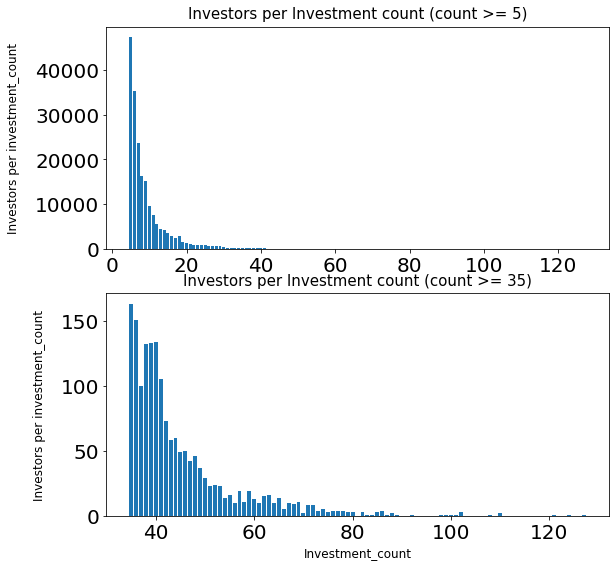

In [25]:
# 3.2 continued: Bargraph of investments per investor
import matplotlib.pyplot as plt

plt.gcf().set_size_inches(9,9)

#subplot with investment_count >= 5
plt.subplot(211)
plt.bar(inv_five.investment_count,inv_five.investors)
plt.title('Investors per Investment count (count >= 5)', y=1.01, fontsize=15)
plt.ylabel('Investors per investment_count',labelpad=15, fontsize=12)

#subplot with investment_count >= 35
plt.subplot(212)
plt.bar(inv_five.loc[inv_five['investment_count'] >= 35].investment_count, inv_five.loc[inv_five['investment_count'] >= 35].investors)
plt.title('Investors per Investment count (count >= 35)', y=1.01, fontsize=15)
plt.xlabel('Investment_count', fontsize=12)
plt.ylabel('Investors per investment_count',labelpad=15, fontsize=12)
plt.show()

The barplots above show the number of investors (y-axis) per investment-count (x-axis). The first barplot shows a range of investment_count between a restricted minimum of 5 and the maximum of 127 investments. The lower plot shows a range from 35 to 127 to show the distribution of investors at the higher end.

In [26]:
# 3.3 Token investors by invesment count (>=5) and by eth.invested
query_eth_by_investor = """
WITH
  first_trf AS(
  SELECT
    DISTINCT tr.token_address AS token,
    MIN(tr.block_timestamp) AS time
  FROM
    `bigquery-public-data.ethereum_blockchain.token_transfers` AS tr
  WHERE
    tr.block_number BETWEEN 510000
    AND 6400000
  GROUP BY
    tr.token_address)
  #issuer per token (issuer =^ most occuring from_address per token within 15 days of first token transfer)
  ,
  issuer AS (
    #select from_address with highest occurrence (occurrence = max_count) per token --> issuer
  SELECT
    DISTINCT tt.token_address AS token1,
    tt.from_address AS issuer1,
    COUNT(tt.from_address) AS c1
  FROM
    `bigquery-public-data.ethereum_blockchain.token_transfers` AS tt
  INNER JOIN (
      #select max_count per token
    SELECT
      token_address,
      MAX(c) AS maxCount
    FROM (
        #count occurrence of from_addresses (potential issuer) per token
      SELECT
        token_address,
        from_address,
        COUNT(from_address) AS c
      FROM
        `bigquery-public-data.ethereum_blockchain.token_transfers`
      JOIN
        first_trf
      ON
        token_address = first_trf.token
      WHERE
        CAST(block_timestamp AS date) <= DATE_ADD(CAST(first_trf.time AS date),INTERVAL 15 DAY)
        AND block_number BETWEEN 5100000
        AND 6400000
      GROUP BY
        token_address,
        from_address)AS tt1
    GROUP BY
      token_address) AS groupedtt
  ON
    tt.token_address = groupedtt.token_address
  JOIN
    first_trf
  ON
    tt.token_address = first_trf.token
  WHERE
    CAST(tt.block_timestamp AS date) <= DATE_ADD(CAST(first_trf.time AS date),INTERVAL 15 DAY)
    AND tt.block_number BETWEEN 5100000
    AND 6400000
  GROUP BY
    tt.token_address,
    tt.from_address,
    groupedtt.maxCount
  HAVING
    groupedtt.maxCount = c1
    AND c1 > 1)
  #select all investors who have once sent a transaction to that contract (cross-check)
SELECT
  DISTINCT investor,
  COUNT(token_contract) as investments,
  sum(value)/power(10,18) as eth_invested
FROM
(SELECT
  investor,
  token_contract,
  token_issuer,
  first_transfer,
  value
FROM (
    #select all investors (investors =^ to_addresses that received a token transfer from the respective issuer)
  SELECT
    DISTINCT t.to_address AS investor,
    symbol,
    issuer.token1 AS token_contract,
    issuer.issuer1 AS token_issuer,
    first_trf.time AS first_transfer
  FROM
    `bigquery-public-data.ethereum_blockchain.token_transfers` AS t
  JOIN
    issuer
  ON
    issuer.issuer1 = t.from_address
    AND issuer.token1 = t.token_address
  JOIN
    `bigquery-public-data.ethereum_blockchain.tokens`
  ON
    address = t.token_address
  JOIN
    first_trf
  ON
    first_trf.token = issuer.token1
  WHERE
    CAST(t.block_timestamp AS date) <= DATE_ADD(CAST(first_trf.time AS date),INTERVAL 15 DAY)
    AND t.block_number BETWEEN 5100000
    AND 6400000
  GROUP BY
    investor,
    token_issuer,
    token1,
    symbol,
    first_trf.time)
  #crosscheck that investor has once made txn to token_contract
INNER JOIN
  `bigquery-public-data.ethereum_blockchain.transactions`
ON
  investor = from_address
WHERE
  to_address = token_contract
GROUP BY
  token_contract,
  investor,
  token_issuer,
  first_transfer,
  value)
GROUP BY
  investor
HAVING
  investments >= 2
ORDER BY
  eth_invested DESC
  """
eth_by_investor = bq_assistant.query_to_pandas(query_eth_by_investor)
eth_by_investor.head()

,investor,investments,eth_invested
0,0x5753930b7d0443dd3769782c169786844db68d49,4,6000.000000
1,0xc5ba57266b29f1b69f0d297affb0f266e5859503,7,3999.300000
2,0x7ec915b8d3ffee3deaae5aa90def8ad826d2e110,126,2487.678033
3,0x0776b16ceeb25d99dbfb12e38cc8836efb2451b7,32,2331.185905
4,0xd64d53513e6bd5a049923a7bd0239e32e92a1a09,20,1690.384395


The previous query returns all investors with the amount invested and the count of tokens that he invested in. It contains a total of 770533 unique investors with a mean (max) of 4 (282) investments and 0.1 (6000) ETH invested.

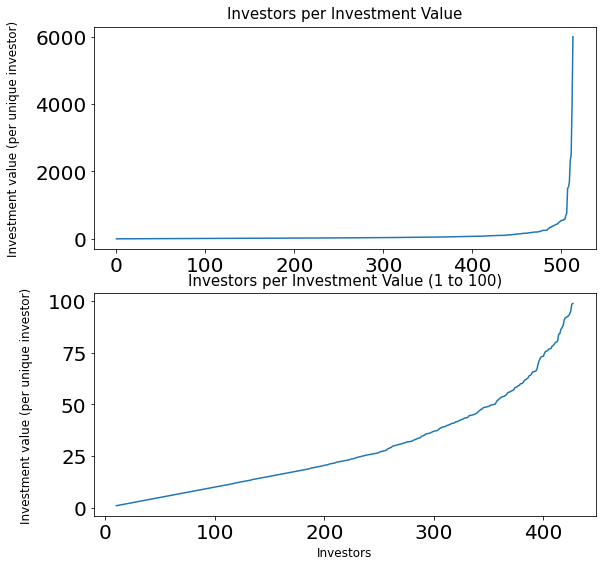

In [27]:
# 3.3 continued: Plots of token investors by investment value
import matplotlib.pyplot as plt

plt.gcf().set_size_inches(9,9)

#round all investments to nearest float with one decimal place and group data by count of eth invested
inv_value_grouped = eth_by_investor.round(1).groupby('eth_invested').size().reset_index(name = 'count')

#subplot including all ether values invested
plt.subplot(211)
plt.plot(inv_value_grouped.eth_invested)
plt.title('Investors per Investment Value', y=1.01, fontsize=15)
plt.ylabel('Investment value (per unique investor)',labelpad=15, fontsize=12)

#limit dataset to ether value from 1 to 100
inv_value_lim = inv_value_grouped.loc[(inv_value_grouped['eth_invested']>= 1) & (inv_value_grouped['eth_invested'] < 100)]

#subplot including ether values invested from 1 to 100
plt.subplot(212)
plt.plot(inv_value_lim.eth_invested)
plt.title('Investors per Investment Value (1 to 100)', y=1.01, fontsize=15)
plt.xlabel('Investors', fontsize=12)
plt.ylabel('Investment value (per unique investor)',labelpad=15, fontsize=12)

plt.show()

The plots above illustrate the number of token investors per ETH value invested. The invested values are rounded to floats with one decimal place. While the first plot has no restriction, the second one looks only at investments between 1 and 100 ether.

That's it for now.

todos:

* Welche user nutzen welche Smart Contracts (wie groß ist das DS)
* Liste an Smart Contracts/ICO die Scams waren (außerhalb GBQ) (andere außergewöhnliche Events)
* Wenn Anfragen zu groß sind, dann Test DS erstellen